## Challenge: A deep dive into Dialogue Act Recognition - PART 1/2
**By**: *Ward Van den Bossche*, **Student ID**: *0605083*

In [40]:
USING_COLAB = False # Change to True if using Google Colab
if USING_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Assuming your notebook is in a subfolder, and you want to go up 1 or more levels to project root
project_root = os.path.dirname(os.getcwd())

# Optional: add root to Python path for module imports
if project_root not in sys.path:
    sys.path.append(project_root)

import matplotlib.pyplot as plt
from collections import Counter
import torch
import json
import torch.nn as nn
import numpy as np
import re

from models import BasicNet
from visualisations import plot_curve, generate_and_plot_confusion_matrix, \
plot_top_symmetric_misclassifications, plot_tsne, plot_tsne_zoomed
from train_structures import run_training_loop, evaluate, predict_single_input
from utils import compute_avg_training_time

# Set random seed for reproducibility
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
parent_dir = os.path.dirname(os.getcwd())
path_to_dataset = os.path.join(parent_dir, 'SGD Dataset') # Assuming we're in a subfolder of the root
path_to_train = os.path.join(path_to_dataset, "TrainSet.json")
path_to_test = os.path.join(path_to_dataset, "TestSet.json")

### Implementation 1: Simple RNN/LSTM (single utterance context)

For the first implementation we'll train a simple RNN and LSTM on the utterances of this dataset. This will be an utterance level model, trained on a single utterance at a time, each word in a single utterance providing context to the next. At inference time the user can then input an utterance and have the system return a dialogue act predicted by the neural network. 

The code is based on an exercise from the course "Deep Learning" of the master applied computer science at VUB, where it was used in an exercise for sentiment analysis. The preprocessing and dataset creation phase needed much adjusting to fit this particular project, but the architecture for the RNN/LSTM remained largely unchanged. 

Because of it's simplicity and reliance only on the given data (i.e. no pretrained embeddings), this implementation will serve as a great benchmark to compare future models with. 

#### Preprocessing
The preprocessing step involves extracting all utterances from the.json files, together with their dialogue acts, which will be used as "labels" in our prediction task. In addition to this, the speaker can be USER or SYSTEM, this information will be encoded in a separate token.

In [43]:
EOD = "<eod>" # Define End of dialogue token as a global variable

A single turn in a dialogue could look like this:
```json
{
    "index": 0,
    "speaker": "USER",
    "utterance": "Hi i need a help, i am very hungry, I am looking for a restaurant",
    "dialogue_act": "USER_INFORM_INTENT",
    "slot": "FindRestaurants"
}
```
The first step is to extract the relevant information from this, i.e. "speaker, "utterance" and "dialogue_act".

In [44]:
def extract_turn_data(file_path):
    all_data = []
    with open(file_path, 'r') as f:
        data = json.load(f)
        for dialogue in data:
            for turn in dialogue['turns']:
                all_data.append({
                    'speaker': turn['speaker'],
                    'utterance': turn['utterance'],
                    'act': turn["dialogue_act"]
                })
            all_data[-1]['utterance'] += f" {EOD}" # Add an End Of Dialogue marker at the end of last utterance in turn
    return all_data

extracted_train = extract_turn_data(path_to_train)
extracted_test = extract_turn_data(path_to_test)

for i in range(22, 25):
    print(extracted_train[i])

{'speaker': 'USER', 'utterance': 'I appreciate it very much. That would be all.', 'act': 'USER_THANK_YOU|USER_GOODBYE'}
{'speaker': 'SYSTEM', 'utterance': 'Have a good time! <eod>', 'act': 'SYSTEM_GOODBYE'}
{'speaker': 'USER', 'utterance': 'Hi i need a help, i am very hungry, I am looking for a restaurant', 'act': 'USER_INFORM_INTENT'}


Next we want to find all unique dialogue acts and assign a label number for each:

In [45]:
# A set makes it easy to find unique elements (removes duplicates)
acts = list(set([data['act'] for data in extracted_train] + [data['act'] for data in extracted_test]))

acts_labels = {act : i for i, act in enumerate(acts)}
inv_acts_labels = {v: k for k, v in acts_labels.items()}

# Get the appropriate labels from each turn (in number form now)
label_train = [ acts_labels[turn['act']] for turn in extracted_train ]
label_test = [ acts_labels[turn['act']] for turn in extracted_test ]

In [46]:
print(acts_labels) 
print(label_train[:5])

{'SYSTEM_OFFER|SYSTEM_INFORM_COUNT': 0, 'USER_INFORM|USER_INFORM_INTENT|USER_SELECT': 1, 'USER_REQUEST|USER_AFFIRM': 2, 'USER_INFORM|USER_INFORM_INTENT': 3, 'SYSTEM_GOODBYE': 4, 'USER_NEGATE': 5, 'USER_INFORM_INTENT': 6, 'USER_SELECT': 7, 'USER_INFORM_INTENT|USER_SELECT': 8, 'USER_NEGATE|USER_GOODBYE': 9, 'USER_NEGATE_INTENT|USER_GOODBYE': 10, 'USER_INFORM|USER_INFORM_INTENT|USER_NEGATE_INTENT': 11, 'USER_INFORM|USER_NEGATE': 12, 'SYSTEM_REQ_MORE': 13, 'SYSTEM_NOTIFY_FAILURE|SYSTEM_REQ_MORE': 14, 'USER_INFORM_INTENT|USER_NEGATE_INTENT': 15, 'SYSTEM_CONFIRM': 16, 'SYSTEM_OFFER_INTENT': 17, 'SYSTEM_REQUEST': 18, 'USER_INFORM|USER_REQUEST_ALTS': 19, 'USER_REQUEST': 20, 'SYSTEM_INFORM|SYSTEM_OFFER|SYSTEM_NOTIFY_FAILURE': 21, 'USER_INFORM|USER_INFORM_INTENT|USER_THANK_YOU': 22, 'SYSTEM_NOTIFY_SUCCESS': 23, 'USER_AFFIRM_INTENT|USER_INFORM': 24, 'USER_AFFIRM': 25, 'SYSTEM_INFORM|SYSTEM_NOTIFY_SUCCESS': 26, 'USER_THANK_YOU|USER_GOODBYE': 27, 'USER_THANK_YOU': 28, 'SYSTEM_INFORM': 29, 'USER_INF

Next we want to extract from every turn the speaker information and clean up the utterances.
Users are assigned number 0 and System is assigned number 1.
Certain tokens like specific price tags are grouped together, while other numbers are also grouped, as they may for example relate to address numbers. Most punctuation is removed but the question mark could be seen as an indicator for REQUEST dialogue acts so it is kept as a separate token.

In [47]:
def clean_utterances(extracted_turns):
    speakers = []
    utterances = []
    
    for data in extracted_turns:
        utterance = data['utterance'].lower()

        # Replace monetary values: "$23.53", "$1,000", "$500"
        utterance = re.sub(r'\$\d+(?:,\d{3})*(?:\.\d{2})?', '<price>', utterance)

        # Replace all remaining numbers with <number>
        utterance = re.sub(r'\b\d+\b', '<number>', utterance)

        # Separate "?" from words (turns "hello?" into "hello ?")
        # such that it can become it's own token and maybe help the model recognize "requests"
        utterance = re.sub(r'(\w+)\?', r'\1 ?', utterance)

        # Remove unwanted characters
        chars_to_erase = ['.', ',', '!', '$']
        for char in chars_to_erase:
            utterance = utterance.replace(char, '')

        utterances.append(utterance)
        if data['speaker'] == 'USER':
            speakers.append(0)
        elif data['speaker'] == 'SYSTEM':
            speakers.append(1)
        else:
            raise ValueError(f"Unknown speaker: {data['speaker']}, expected USER or SYSTEM")
    
    return speakers, utterances


In [132]:
speakers_train, utterances_train = clean_utterances(extracted_train)
speakers_test, utterances_test = clean_utterances(extracted_test)

In [133]:
print(len(speakers_train), len(utterances_train), len(label_train))
print(len(speakers_test), len(utterances_test), len(label_test))
print(list(set(speakers_train)))
# Sanity check
assert len(speakers_train) == len(utterances_train) == len(label_train), "Lengths of speakers, utterances and labels do not match"

82588 82588 82588
16850 16850 16850
[0, 1]


After cleaning up the contents of the utterances, we remove words that occur less than 5 times. This approach has multiple benefits:
- a smaller vocabulary leads to faster training and less memory usage
- the model will avoid overfitting to rare tokens
- familiarizing the model with unkown tokens (**\<unk\>**) will make the model more robust to new data (even in the context of this project, the test data may include words never encountered in the train set)

Some additional tokens like \<start\> and \<end\> and \<eod\> are added to help the model with it's decision. (e.g. end of dialogue token will likely result in a "SYSTEM_GOODBYE" Dialogue Act).

In the final step each utterance is encoded to it's number equivalent. This will make it possible to create an embedding table (with learnable weights) such that each word is mapped to an embedding of embed_size. The end result is a look-up table where you can get a word's embedding by using it's number as an index in the lookup table. The hope is that in training the model, words with semantic meanings will be closer together in the embedding space.

This in turn will help the RNN classify utterances more effectively, since a sentence like:
"Can you help me ?" and "Could you assist me ?" might look similar in the embedding space, even with different words, and the RNN would classify them both as requests.

In [50]:
word_freq = Counter()
for utterance in utterances_train:
    utterance_words = utterance.split()
    word_freq.update(utterance_words)

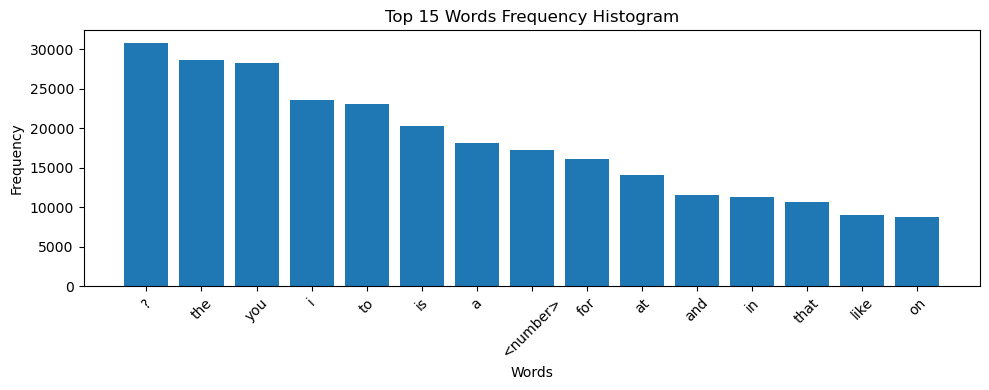

In [51]:
# lets have a look at the top 10 words
top_words = [word for word, count in word_freq.most_common(15)]
top_frequencies = [count for word, count in word_freq.most_common(15)]

# Create a bar plot for the top 5 words
plt.figure(figsize=(10,4))
plt.bar(top_words, top_frequencies)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 15 Words Frequency Histogram")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [52]:
min_word_freq = 5
words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
word_map = {k: v + 1 for v, k in enumerate(words)}
word_map['<unk>'] = len(word_map) + 1
word_map['<start>'] = len(word_map) + 1
word_map['<end>'] = len(word_map) + 1
word_map['<pad>'] = 0
rev_word_map = {v: k for k, v in word_map.items()}

print(f"Total words are: {len(word_map)}")

Total words are: 2704


In [53]:
def encode_text(utterances, max_len):
    """
    Assign a numerical value (0 to len(word_map)) to each word in the
    utterance while handling special tokens.
    """
    encoded_texts = []
    
    for utterance in utterances:
        utterance_words = utterance.lower().split()
        is_last_utterance = utterance_words[-1] == EOD.lower()
        if is_last_utterance:
            utterance_words = utterance_words[:-1] # eod is added after the end token later
        adjusted_max_len = max_len - (3 if is_last_utterance else 2)  # Adjust for special tokens
        words = utterance_words[:adjusted_max_len]

        # Tokenization with special tokens
        tokenized = [word_map['<start>']]
        tokenized += [word_map.get(word, word_map['<unk>']) for word in words]
        tokenized.append(word_map['<end>'])
        
        if is_last_utterance:
            tokenized.append(word_map[EOD])
        
        # Padding
        tokenized += [word_map['<pad>']] * (adjusted_max_len - len(words))
        
        encoded_texts.append(tokenized)
    
    return encoded_texts


In [54]:
encoded_texts = encode_text(utterances_train, max_len = 100)
encoded_texts_test = encode_text(utterances_test, max_len = 100)

In [55]:
# test one sample
example_tokens = encoded_texts[23]
print("Original utterance:")
print(" ".join([rev_word_map[t] for t in example_tokens]))
print("Encoded tokens:")
print(example_tokens)
print("Total length:") #should always be max_len (100 in this case)
print(len(example_tokens))

Original utterance:
<start> have a good time <end> <eod> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Encoded tokens:
[2702, 15, 10, 51, 91, 2703, 125, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Total length:
100


#### Dataset and Data Loaders

In [56]:
X_utterances_train = torch.tensor(encoded_texts)    # (number_of_samples, max_length)
X_speakers_train = torch.nn.functional.one_hot(torch.tensor(speakers_train), num_classes=2) 
# In accordance with the paper, we will pass the speakers as one-hot vectors along with the utterance
y_train = torch.LongTensor(label_train)  # (number_of_samples)

train_dataset = torch.utils.data.TensorDataset(X_utterances_train, X_speakers_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=128,
                                           num_workers=6, 
                                           shuffle=True)

X_utterances_test = torch.tensor(encoded_texts_test)
X_speakers_test = torch.nn.functional.one_hot(torch.tensor(speakers_test), num_classes=2)
y_test = torch.LongTensor(label_test)

test_dataset = torch.utils.data.TensorDataset(X_utterances_test, X_speakers_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                        batch_size=128,
                                        shuffle=False)

In [57]:
utterances, speakers, labels = next(iter(train_loader))
print(utterances.shape, speakers.shape, labels.shape)

torch.Size([128, 100]) torch.Size([128, 2]) torch.Size([128])


#### Architectures

For the architectures the reader is referred to the **models.py** file. There they will find an RNN and LSTM implementation, and a final BasicNet implementation that makes use of the aforementioned learned embedding, the weights of which are being also being updated during training.

#### Training

For the general training loop the reader is referred to the train() and run_training_loop() functions in **train_structures.py**. All we have to do here is to define a model-specific prepare_batch and forward function.

In [58]:
def prepare_batch_v1(batch):
    inputs, speakers, targets = batch
    return [inputs, speakers], targets

def forward_v1(model, inputs, speakers):
    return model(inputs, speakers)

It's time to define our model, the parameters were chosen based on these findings:

- According to the paper (see implementation 2 later), taking the **average** RNN state carried more information about the DA than the last hidden state, which was confirmed here because the last_hidden_state model reached an accuracy of about 11%, while the average model reached 84.6%.
- [An article from a google developer](https://developers.googleblog.com/en/introducing-tensorflow-feature-columns/) recommends putting the **embedding dimension** to nr_of_categories ** 0.25.
embedding_size = number_of_categories<sup>0.25</sup>, we have about 3000 words, 3000<sup>0.25</sup> rounded up = 8
- According to chatGPT **hidden size** should be about 2-4 times the embedding size (so 8*4 = 32)
- It makes use of an LSTM (see implementation), which is, simply put, a more complex variant of RNN, but this can easily be changed to a basic RNN in the code.

In [59]:
model = BasicNet(
    input_embedding_size = 8, 
    hidden_size = 32, 
    num_words=len(word_map), 
    num_classes=len(acts_labels), 
    pooling_type="average").to(device)

In [60]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 50

losses, accuracies = run_training_loop(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=num_epochs,
    prepare_batch=prepare_batch_v1,
    forward=forward_v1,
    save_dir="train_logs"
)

100%|██████████| 646/646 [01:18<00:00,  8.20it/s]


Epoch 1/50, Train Loss: 2.881, Train Accuracy: 21.661


100%|██████████| 646/646 [01:19<00:00,  8.17it/s]


Epoch 2/50, Train Loss: 2.374, Train Accuracy: 28.829


100%|██████████| 646/646 [01:15<00:00,  8.51it/s]


Epoch 3/50, Train Loss: 2.025, Train Accuracy: 36.952


100%|██████████| 646/646 [01:12<00:00,  8.89it/s]


Epoch 4/50, Train Loss: 1.769, Train Accuracy: 42.753


100%|██████████| 646/646 [01:12<00:00,  8.88it/s]


Epoch 5/50, Train Loss: 1.620, Train Accuracy: 47.452


100%|██████████| 646/646 [01:12<00:00,  8.86it/s]


Epoch 6/50, Train Loss: 1.503, Train Accuracy: 50.673


100%|██████████| 646/646 [01:12<00:00,  8.93it/s]


Epoch 7/50, Train Loss: 1.340, Train Accuracy: 56.660


100%|██████████| 646/646 [01:12<00:00,  8.88it/s]


Epoch 8/50, Train Loss: 1.218, Train Accuracy: 60.209


100%|██████████| 646/646 [01:12<00:00,  8.91it/s]


Epoch 9/50, Train Loss: 1.118, Train Accuracy: 63.887


100%|██████████| 646/646 [01:12<00:00,  8.94it/s]


Epoch 10/50, Train Loss: 1.008, Train Accuracy: 66.471


100%|██████████| 646/646 [01:12<00:00,  8.92it/s]


Epoch 11/50, Train Loss: 0.913, Train Accuracy: 69.111


100%|██████████| 646/646 [01:12<00:00,  8.91it/s]


Epoch 12/50, Train Loss: 0.848, Train Accuracy: 71.135


100%|██████████| 646/646 [01:18<00:00,  8.19it/s]


Epoch 13/50, Train Loss: 0.787, Train Accuracy: 72.868


100%|██████████| 646/646 [01:14<00:00,  8.69it/s]


Epoch 14/50, Train Loss: 0.724, Train Accuracy: 75.390


100%|██████████| 646/646 [01:14<00:00,  8.68it/s]


Epoch 15/50, Train Loss: 0.665, Train Accuracy: 78.250


100%|██████████| 646/646 [01:14<00:00,  8.64it/s]


Epoch 16/50, Train Loss: 0.615, Train Accuracy: 80.495


100%|██████████| 646/646 [01:15<00:00,  8.56it/s]


Epoch 17/50, Train Loss: 0.552, Train Accuracy: 82.633


100%|██████████| 646/646 [01:16<00:00,  8.46it/s]


Epoch 18/50, Train Loss: 0.551, Train Accuracy: 82.836


100%|██████████| 646/646 [01:15<00:00,  8.55it/s]


Epoch 19/50, Train Loss: 0.505, Train Accuracy: 84.695


100%|██████████| 646/646 [01:14<00:00,  8.67it/s]


Epoch 20/50, Train Loss: 0.463, Train Accuracy: 86.012


100%|██████████| 646/646 [01:15<00:00,  8.57it/s]


Epoch 21/50, Train Loss: 0.426, Train Accuracy: 87.341


100%|██████████| 646/646 [01:14<00:00,  8.65it/s]


Epoch 22/50, Train Loss: 0.409, Train Accuracy: 87.809


100%|██████████| 646/646 [01:14<00:00,  8.69it/s]


Epoch 23/50, Train Loss: 0.390, Train Accuracy: 88.377


100%|██████████| 646/646 [01:14<00:00,  8.67it/s]


Epoch 24/50, Train Loss: 0.372, Train Accuracy: 88.938


100%|██████████| 646/646 [01:15<00:00,  8.52it/s]


Epoch 25/50, Train Loss: 0.356, Train Accuracy: 89.421


100%|██████████| 646/646 [01:14<00:00,  8.68it/s]


Epoch 26/50, Train Loss: 0.343, Train Accuracy: 89.722


100%|██████████| 646/646 [01:17<00:00,  8.36it/s]


Epoch 27/50, Train Loss: 0.332, Train Accuracy: 90.011


100%|██████████| 646/646 [01:17<00:00,  8.34it/s]


Epoch 28/50, Train Loss: 0.322, Train Accuracy: 90.410


100%|██████████| 646/646 [01:18<00:00,  8.26it/s]


Epoch 29/50, Train Loss: 0.309, Train Accuracy: 90.719


100%|██████████| 646/646 [01:18<00:00,  8.26it/s]


Epoch 30/50, Train Loss: 0.301, Train Accuracy: 90.996


100%|██████████| 646/646 [01:17<00:00,  8.35it/s]


Epoch 31/50, Train Loss: 0.294, Train Accuracy: 91.174


100%|██████████| 646/646 [01:16<00:00,  8.42it/s]


Epoch 32/50, Train Loss: 0.284, Train Accuracy: 91.447


100%|██████████| 646/646 [01:18<00:00,  8.23it/s]


Epoch 33/50, Train Loss: 0.277, Train Accuracy: 91.707


100%|██████████| 646/646 [01:13<00:00,  8.79it/s]


Epoch 34/50, Train Loss: 0.276, Train Accuracy: 91.702


100%|██████████| 646/646 [01:12<00:00,  8.96it/s]


Epoch 35/50, Train Loss: 0.263, Train Accuracy: 92.098


100%|██████████| 646/646 [01:13<00:00,  8.75it/s]


Epoch 36/50, Train Loss: 0.257, Train Accuracy: 92.206


100%|██████████| 646/646 [01:18<00:00,  8.26it/s]


Epoch 37/50, Train Loss: 0.253, Train Accuracy: 92.403


100%|██████████| 646/646 [01:21<00:00,  7.88it/s]


Epoch 38/50, Train Loss: 0.246, Train Accuracy: 92.538


100%|██████████| 646/646 [01:20<00:00,  8.02it/s]


Epoch 39/50, Train Loss: 0.243, Train Accuracy: 92.633


100%|██████████| 646/646 [01:22<00:00,  7.83it/s]


Epoch 40/50, Train Loss: 0.236, Train Accuracy: 92.857


100%|██████████| 646/646 [01:18<00:00,  8.22it/s]


Epoch 41/50, Train Loss: 0.233, Train Accuracy: 92.918


100%|██████████| 646/646 [01:15<00:00,  8.58it/s]


Epoch 42/50, Train Loss: 0.228, Train Accuracy: 93.000


100%|██████████| 646/646 [01:15<00:00,  8.57it/s]


Epoch 43/50, Train Loss: 0.225, Train Accuracy: 93.208


100%|██████████| 646/646 [01:15<00:00,  8.51it/s]


Epoch 44/50, Train Loss: 0.221, Train Accuracy: 93.269


100%|██████████| 646/646 [01:15<00:00,  8.59it/s]


Epoch 45/50, Train Loss: 0.228, Train Accuracy: 93.095


100%|██████████| 646/646 [01:15<00:00,  8.53it/s]


Epoch 46/50, Train Loss: 0.220, Train Accuracy: 93.371


100%|██████████| 646/646 [01:15<00:00,  8.59it/s]


Epoch 47/50, Train Loss: 0.215, Train Accuracy: 93.531


100%|██████████| 646/646 [01:15<00:00,  8.55it/s]


Epoch 48/50, Train Loss: 0.210, Train Accuracy: 93.653


100%|██████████| 646/646 [01:15<00:00,  8.56it/s]


Epoch 49/50, Train Loss: 0.209, Train Accuracy: 93.695


100%|██████████| 646/646 [01:16<00:00,  8.47it/s]

Epoch 50/50, Train Loss: 0.213, Train Accuracy: 93.463

 Training complete. Model saved to 'train_logs\model.pth', stats saved to 'train_logs\train_stats.csv'


In [2]:
compute_avg_training_time('train_logs/train_stats.csv')

Average training time is: 75.7083416557312 seconds


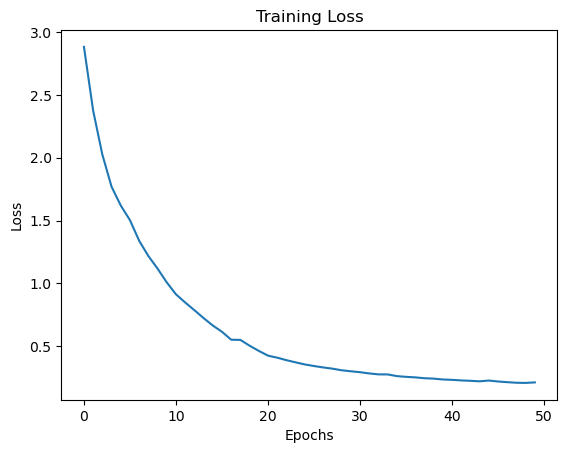

In [61]:
plot_curve(losses, "Epochs", "Loss", "Training Loss")

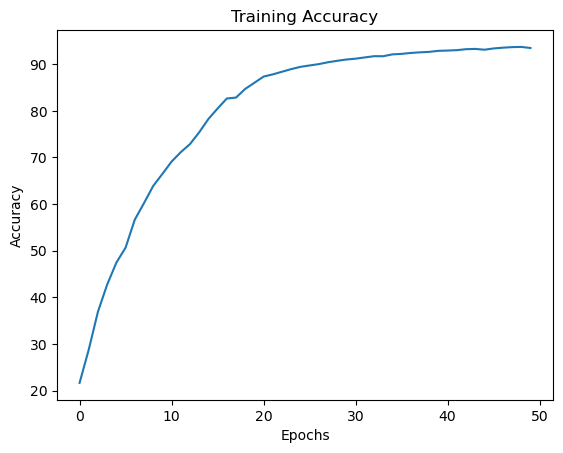

In [62]:
plot_curve(accuracies, "Epochs", "Accuracy", "Training Accuracy")

#### Evaluation and Inference

We evaluate the model and test a user input for inference. Please refer to the evaluate() function in **train_structures.py**

In [89]:
metrics = evaluate(model, test_loader, prepare_batch_fn=prepare_batch_v1, 
                   forward_fn=forward_v1, inv_act_labels=inv_acts_labels)

100%|██████████| 132/132 [00:08<00:00, 14.94it/s]
c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



 Evaluation Results:
Top-1 Accuracy: 83.98%
Top-5 Accuracy: 97.79%
Balanced Accuracy: 69.87%

 Classification Report:
                                                   precision    recall  f1-score   support

                                   SYSTEM_CONFIRM       0.92      0.90      0.91      1113
                                   SYSTEM_GOODBYE       1.00      1.00      1.00      1331
                                    SYSTEM_INFORM       0.83      0.81      0.82       719
              SYSTEM_INFORM|SYSTEM_NOTIFY_SUCCESS       0.78      0.76      0.77       310
 SYSTEM_INFORM|SYSTEM_OFFER|SYSTEM_NOTIFY_FAILURE       0.50      0.29      0.37        17
            SYSTEM_NOTIFY_FAILURE|SYSTEM_REQ_MORE       0.94      0.95      0.94        79
                            SYSTEM_NOTIFY_SUCCESS       0.88      0.94      0.91       499
                                     SYSTEM_OFFER       0.82      0.77      0.80       806
                              SYSTEM_OFFER_INTENT       0.78 

For inference we test on an existing input, and a test_sentence in the cell below, which can be adjusted by the reader.

In [64]:
sample, speaker_id, target = test_dataset[0]
target = target.item()
speaker_id = speaker_id.unsqueeze(0)

output, prob, pred = predict_single_input(
    model,
    text=sample,
    speaker_id=speaker_id,
    target_label=target,
    is_text_encoded=True,
    rev_word_map=rev_word_map,
    label_map=inv_acts_labels
)


Inference Results
Input: <start> hi could you get me a restaurant booking on the 8th please ? <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Prediction: USER_INFORM|USER_INFORM_INTENT (3) with probability 0.985
True Label: USER_INFORM|USER_INFORM_INTENT (3)

Top-5 Predictions:
USER_INFORM|USER_INFORM_INTENT: 0.985
USER_INFORM: 0.005
USER_INFORM|USER_INFORM_INTENT|USER_SELECT: 0.004
USER_INFORM|USER_REQUEST_ALTS: 0.004
USER_INFORM_INTENT: 0.002


An interesting experiment reveals that the model is highly confident in it's "SYSTEM_GOODBYE" prediction when an \<eod\> token is present in the utterance string. And as expected the presence of the speaker_id narrows down the possibilities to (mostly) USER_[act] or SYSTEM_[act] predictions depending on the speaker.

In [ ]:
test_sentence = "No problem, goodbye! <eod>"
test_speaker_id = torch.tensor([0, 1]).unsqueeze(0) # [1, 0] for USER and [0, 1] for SYSTEM
test_target = acts_labels['SYSTEM_GOODBYE']

_ = predict_single_input(
    model,
    text=test_sentence,
    speaker_id=test_speaker_id,
    target_label=test_target,
    is_text_encoded=False,
    rev_word_map=rev_word_map,
    label_map=inv_acts_labels,
    preprocess_fn=clean_utterances,
    encode_fn=encode_text
)


Inference Results
Encoded input: <start> no problem goodbye <end> <eod> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Prediction: SYSTEM_GOODBYE (4) with probability 1.000
True Label: SYSTEM_GOODBYE (4)

Top-5 Predictions:
SYSTEM_GOODBYE: 1.000
SYSTEM_NOTIFY_SUCCESS: 0.000
SYSTEM_REQ_MORE: 0.000
SYSTEM_INFORM: 0.000
SYSTEM_REQUEST: 0.000


#### Visualisations

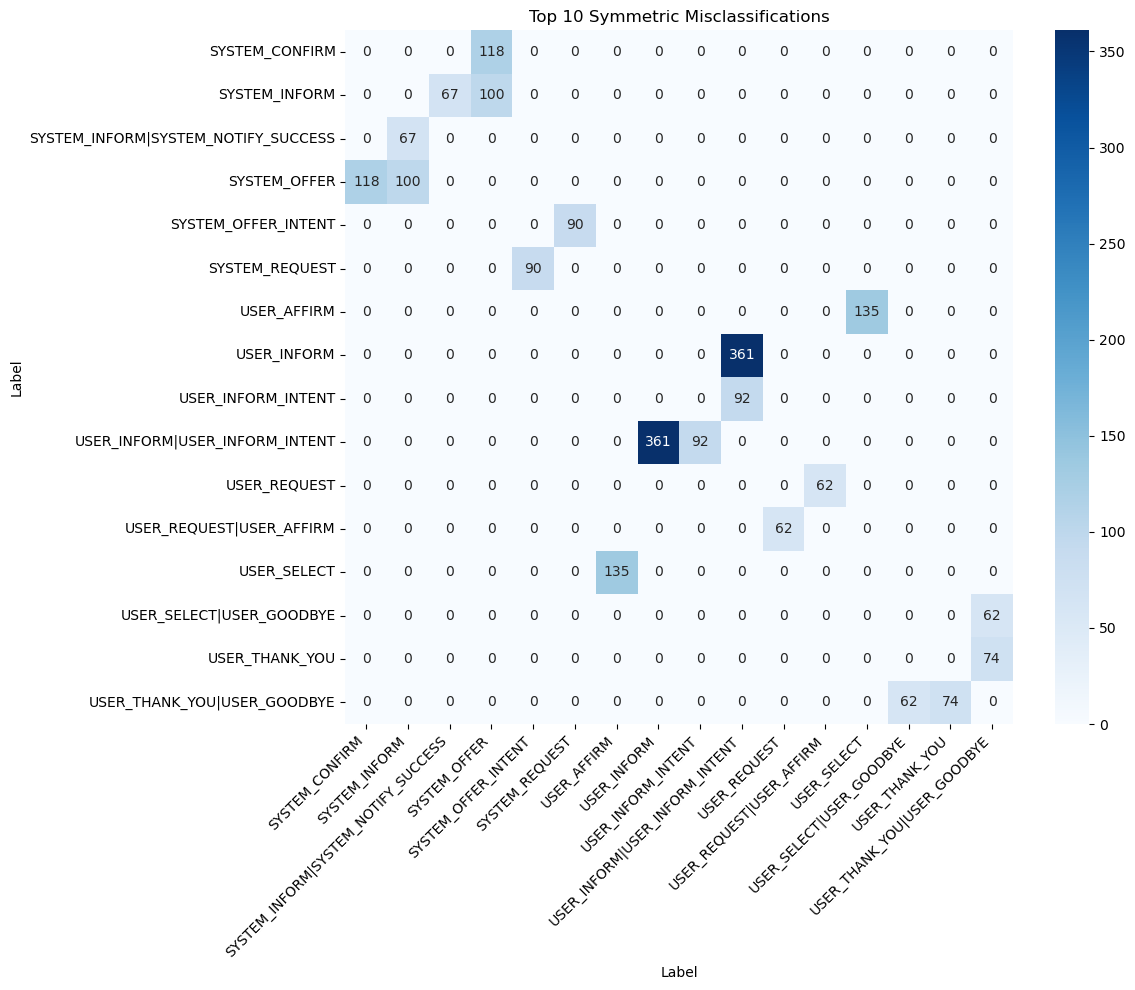

In [71]:
all_targets_named = metrics['y_true']
all_predictions_named = metrics['y_pred']

# Call the function to plot the top 10 misclassifications
plot_top_symmetric_misclassifications(all_targets_named, all_predictions_named, top_n=10)

Full version below, for closer inspection look at the generated files and zoom in if needed. Note that here the distinction is made between (predicted, true) and (true, predicted) while in the previous matrix they were summed together (i.e. (SYSTEM_CONFIRM, SYSTEM_INFORM) vs (SYSTEM_INFORM, SYSTEM_CONFIRM) was considered the same).

Found 39 unique classes.
Generating confusion matrix plot...
Saved matrix plots to full_confusion_matrix.pdf and .png


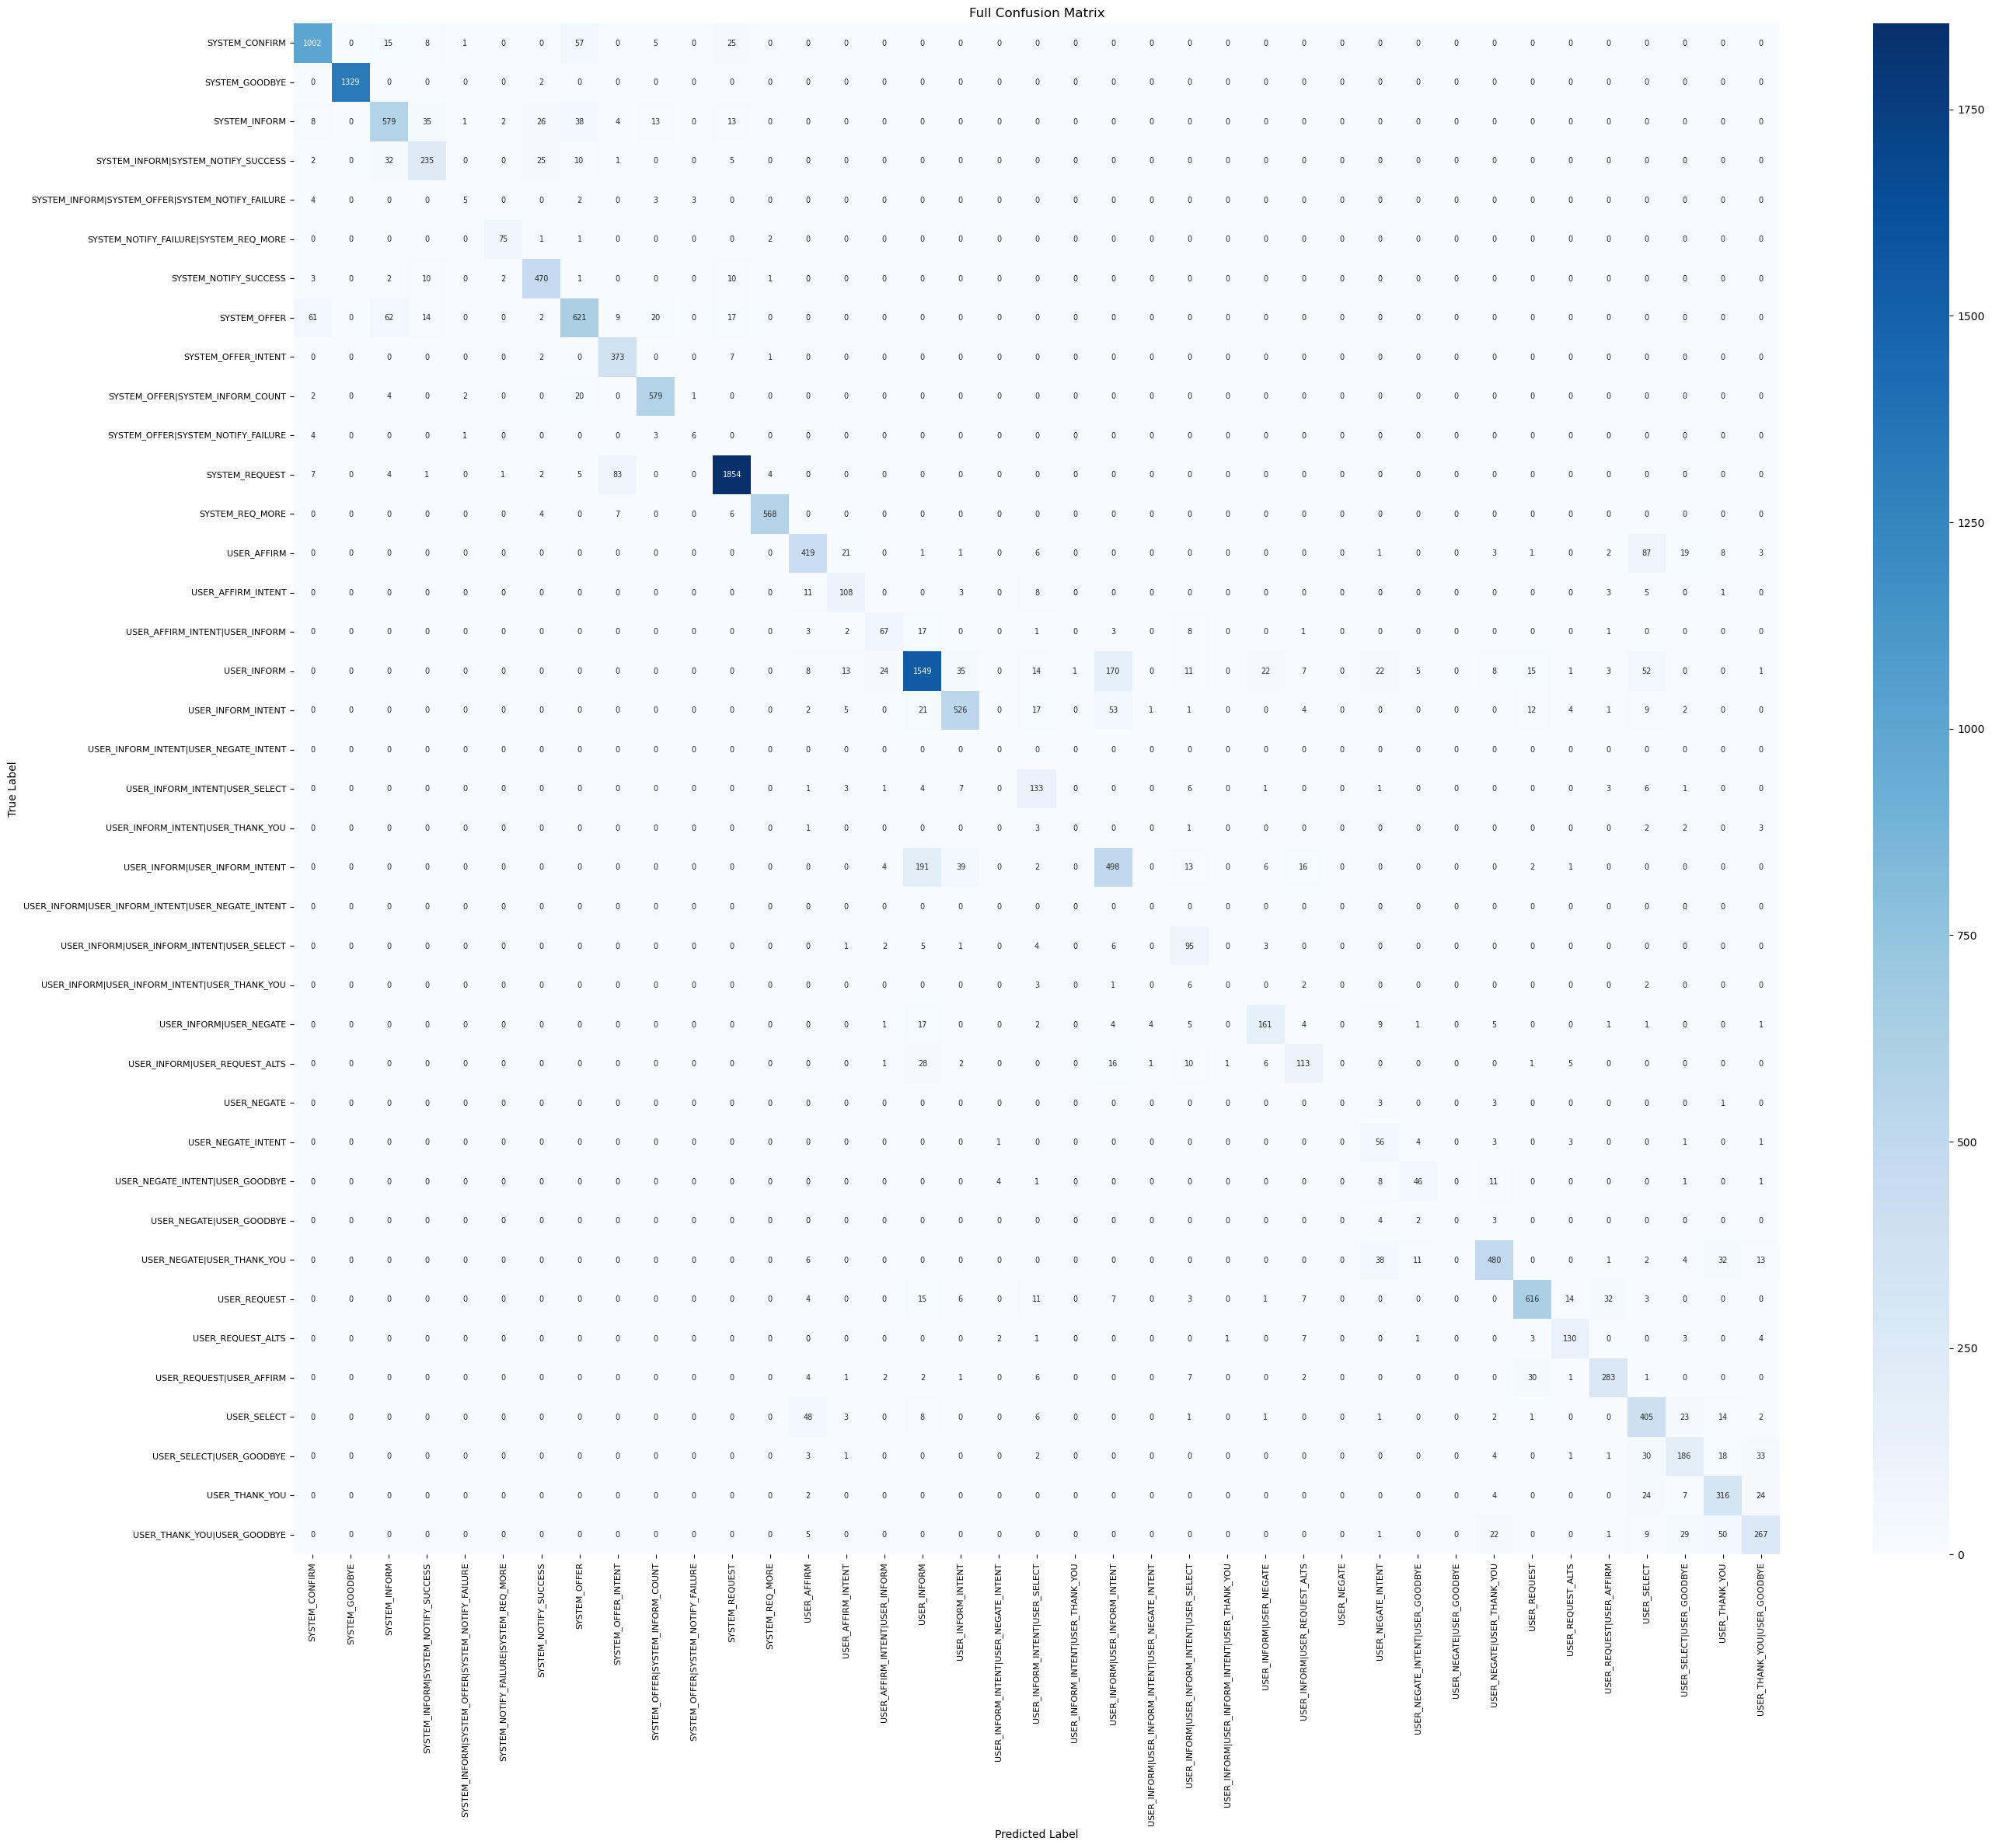

In [72]:
generate_and_plot_confusion_matrix(
    all_targets_named,
    all_predictions_named,
    figsize=(28, 24),        # Customize plot size
    annot_kws={"size": 7}    # Customize annotation font size
)

Finally we plot a subset of the utterances, for clarity purposes only the top 10 most common dialogue acts are shown, but the user can insert their own subset by providing a custom list.

Saved plots to t-SNE of Top 10 Occuring Dialogue Acts.png


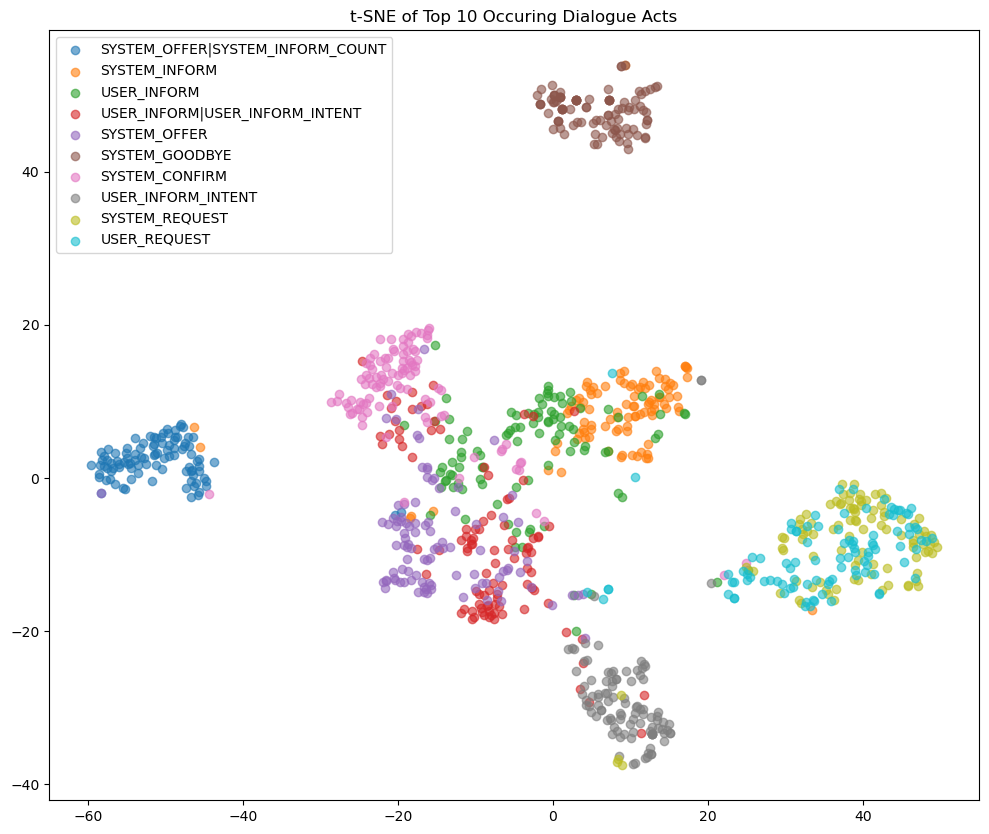

In [130]:
utterances = metrics["utterance_vectors"]
labels = metrics["y_true"]

# Filter the utterances and labels to only include the top labels
label_counts = Counter(metrics["y_true"])
top_labels = [label for label, _ in label_counts.most_common(10)]

plot_tsne(utterances, labels, top_labels, max_per_label=100, title="t-SNE of Top 10 Occuring Dialogue Acts")

A "zoomed in" version reveals some specific utterances, and confirms that similar utterances are clustered together.

Saved plots to t-SNE of User Requests and System Inform Acts.png


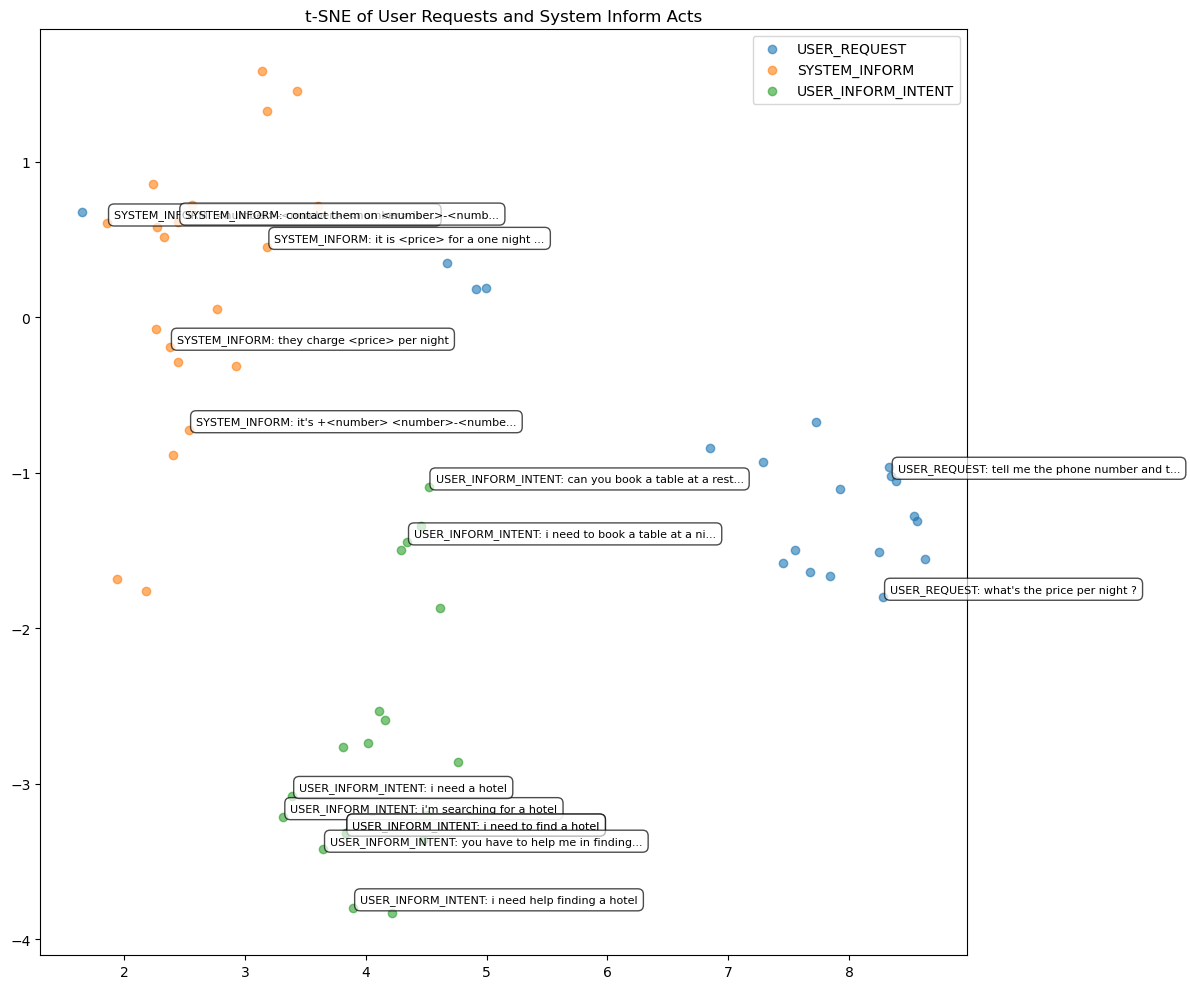

In [ ]:
# Plot zoomed version for just a specific subset of acts
plot_tsne_zoomed(
    vectors=utterances,
    labels=labels,
    texts=utterances_test,
    selected_labels=['USER_REQUEST', 'SYSTEM_INFORM', 'USER_INFORM_INTENT'],  # Focus on these classes
    max_per_label=20,              # Limit points per class
    annotate_sample=0.3,           # Annotate 30% of points
    zoom_scale=1.0,                
    title="t-SNE of User Requests and System Inform Acts",
)